<a href="https://colab.research.google.com/github/kregier/Springboard/blob/master/LanguageClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Language classsifier
Identify the gender and/or native language of speakers reading a fixed passage in English.

The goal is to use the pre-trained vggish model to extract features from audio files, and train a classifier to identify the gender and/or native language or the speaker.

The data is a subset of the Speech Accent Archive, available from https://www.kaggle.com/rtatman/speech-accent-archive

In [3]:
# Set up the environment
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

import os

import tensorflow as tf
import tensorflow_hub as hub

In [ ]:
# Load the vggish model from the TF hub
model = hub.load('https://tfhub.dev/google/vggish/1')

# Data wrangling
- Load the data (or at least the metadata)
- Perform EDA
- Select the desired subset of the data

In [4]:
# Set up the data import using Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

# Change working directory
%cd /content/gdrive/My Drive/Kaggle
!ls

/content/gdrive/My Drive/Kaggle
kaggle.json


In [6]:
# Copy Kaggle API command
#!kaggle datasets download -d rtatman/speech-accent-archive

100% 863M/865M [00:10<00:00, 60.3MB/s]
100% 865M/865M [00:10<00:00, 89.6MB/s]


In [7]:
!ls

kaggle.json  speech-accent-archive.zip


In [8]:
# unzip the zip files and remove the zip files
#!unzip \*.zip && rm *.zip

Archive:  speech-accent-archive.zip
  inflating: reading-passage.txt     
  inflating: recordings/recordings/afrikaans1.mp3  
  inflating: recordings/recordings/afrikaans2.mp3  
  inflating: recordings/recordings/afrikaans3.mp3  
  inflating: recordings/recordings/afrikaans4.mp3  
  inflating: recordings/recordings/afrikaans5.mp3  
  inflating: recordings/recordings/agni1.mp3  
  inflating: recordings/recordings/akan1.mp3  
  inflating: recordings/recordings/albanian1.mp3  
  inflating: recordings/recordings/albanian2.mp3  
  inflating: recordings/recordings/albanian3.mp3  
  inflating: recordings/recordings/albanian4.mp3  
  inflating: recordings/recordings/albanian5.mp3  
  inflating: recordings/recordings/albanian6.mp3  
  inflating: recordings/recordings/albanian7.mp3  
  inflating: recordings/recordings/albanian8.mp3  
  inflating: recordings/recordings/albanian9.mp3  
  inflating: recordings/recordings/amazigh1.mp3  
  inflating: recordings/recordings/amazigh2.mp3  
  inflating: 

In [9]:
!ls

kaggle.json  reading-passage.txt  recordings  speakers_all.csv


In [13]:
text = pd.read_csv('reading-passage.txt', header=None, delimiter='.')
text.head()

,0,1,2,3,4
0,Please call Stella,Ask her to bring these things with her from ...,We also need a small plastic snake and a big...,She can scoop these things into three red ba...,NaN


In [19]:
meta = pd.read_csv('speakers_all.csv')
meta.head()

In [25]:
# Drop 3 end columns with NaN values
#meta.drop(['Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11'], axis=1, inplace=True)

# Set speakerid as index
#meta.set_index('speakerid', inplace=True)
meta.sort_index(inplace=True)
meta.head()

,age,age_onset,birthplace,filename,native_language,sex,country,file_missing?
speakerid,,,,,,,,
1,27.0,9.0,"virginia, south africa",afrikaans1,afrikaans,female,south africa,False
2,40.0,5.0,"pretoria, south africa",afrikaans2,afrikaans,male,south africa,False
3,25.0,15.0,"diekabo, ivory coast",agni1,agni,male,ivory coast,False
4,19.0,6.0,"prishtina, kosovo",albanian1,albanian,male,kosovo,False
5,33.0,15.0,"tirana, albania",albanian2,albanian,male,albania,False


## EDA
- How many speakers per native language?
- What are the top languages present in the database?
- How many dialects of English are represented? (native_language == English, by birthplace values)
- What is the distribution of speakers by gender and language?

In [27]:
# How many unique values are there per column?
meta.nunique()

age                  80
age_onset            59
birthplace         1290
filename           2156
native_language     214
sex                   3
country             176
file_missing?         2
dtype: int64

In [38]:
# How many speakers per native language?
# Hard to see the scope because there are so many with only one speaker
meta.native_language.value_counts()

english     579
spanish     162
arabic      102
mandarin     65
french       63
           ... 
hindko        1
mizo          1
mandingo      1
kabyle        1
nama          1
Name: native_language, Length: 215, dtype: int64

In [51]:
# Top 10 languages in the dataset, in addition to English
lang_counts = meta.native_language.value_counts().head(11)
lang_counts

english       579
spanish       162
arabic        102
mandarin       65
french         63
korean         52
portuguese     48
russian        48
dutch          47
turkish        37
german         36
Name: native_language, dtype: int64

In [56]:
lang_list = ['spanish', 'arabic', 'mandarin', 'french', 'korean', 'portuguese', 
             'russian', 'dutch', 'turkish', 'german']
top_lang = meta.loc[meta.native_language.isin(lang_list)]

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 10 Text major ticklabel objects>)

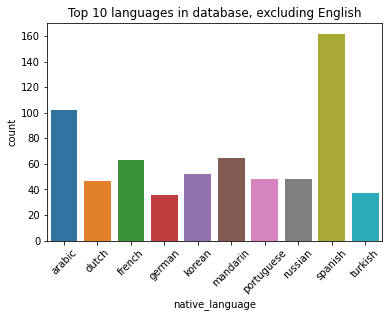

In [61]:
sns.countplot(x='native_language', data=top_lang)
plt.title('Top 10 languages in database, excluding English')
plt.xticks(rotation=45)

In [62]:
# What is the distribution of speakers by gender?
meta.loc[meta.loc[:,'sex']=='famale'] = 'female'
meta.sex.value_counts()

male      1123
female    1049
Name: sex, dtype: int64

Text(0.5, 1.0, 'Distibution of speakers by gender - Whole database')

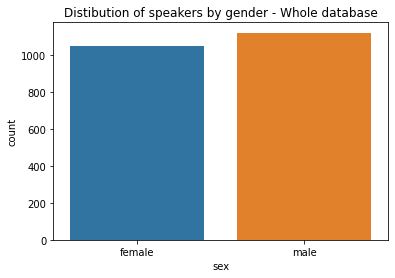

In [65]:
sns.countplot(x='sex', data=meta)
plt.title('Distibution of speakers by gender - Whole database')

Text(0.5, 1.0, 'Distribution of speakers by gender - Top languages')

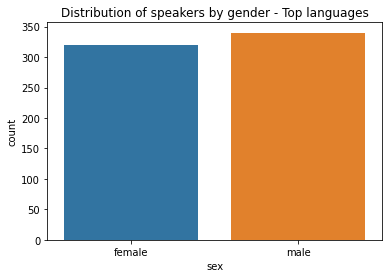

In [67]:
sns.countplot(x='sex', data=top_lang)
plt.title('Distribution of speakers by gender - Top languages')

In [36]:
# How many varieties of English are represented in the database?
english = meta.loc[meta.native_language == 'english']
english.country.value_counts()

usa                     373
uk                       65
canada                   44
australia                32
ireland                  11
new zealand               8
jamaica                   5
singapore                 4
south africa              4
india                     3
panama                    3
philippines               2
guyana                    2
malaysia                  2
lebanon                   1
isle of man               1
spain                     1
virginia                  1
ghana                     1
papua new guinea          1
italy                     1
switzerland               1
germany                   1
belize                    1
nigeria                   1
liberia                   1
antigua and barbuda       1
bolivia                   1
barbados                  1
united arab emirates      1
pakistan                  1
the bahamas               1
fiji                      1
trinidad                  1
us virgin islands         1
Name: country, dtype

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34]), <a list of 35 Text major ticklabel objects>)

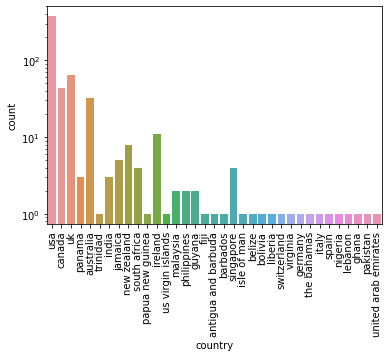

In [72]:
sns.countplot(x='country', data=english)
plt.yscale('log')
plt.xticks(rotation=90)

# Data Augmentation
- Break paragraph into sentences by dividing at pauses
- Add random noise (at varying levels) to the files
- Possible pitch manipulation

# Gender classifier
- binary options: logistic regression, sigmoid function?

# Build a model
- Feature extraction from vggish
- Gender classifier layers

# Train the model

# Evaluate the results